<a href="https://colab.research.google.com/github/JorgeFMDelgado/PINNs/blob/main/NN_SimpleODE_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN to solve $y' + 2 y = 3 e^t$ with $y(0) = 3$ for $t \in [0,3]$
Solution: $y = 2e^{-2t} + e^t$

This is purely implementing PyTorch.

In [ ]:
import torch as torch
import torch.utils.data as D
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### Configuration of the problem

In [ ]:
tInicial = 0
tFinal = 3

In [ ]:
nPoints = 10000
nValid = 1000
nTrain = nPoints-nValid

### Preparation of dataset and dataloaders

In [ ]:
x_data = (tFinal-tInicial)*torch.rand(1,nPoints).view(-1,1)
y_data = torch.zeros_like(x_data)

In [ ]:
# Dataset with all data
dset_data = D.TensorDataset(x_data,y_data)

In [ ]:
# Random Split of the dataset with all data into two for training and validation
dset_train, dset_valid = D.random_split(dset_data,[nTrain,nValid])

In [ ]:
dl_train = D.DataLoader(dset_train,batch_size=100,shuffle=True)
dl_valid = D.DataLoader(dset_valid,batch_size=100,shuffle=False)

### Model

In [ ]:
class Simple_net(torch.nn.Module):
  def __init__(self):
    super(Simple_net,self).__init__()
    self.fc1 = nn.Linear(1,100)
    self.fc2 = nn.Linear(100,500)
    self.fc3 = nn.Linear(500,1000)
    self.fc4 = nn.Linear(1000,1)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

  def reset_weights(self):
    torch.nn.init.kaiming_uniform_(self.fc1.weight)
    torch.nn.init.kaiming_uniform_(self.fc2.weight)
    torch.nn.init.kaiming_uniform_(self.fc3.weight)
    torch.nn.init.kaiming_uniform_(self.fc4.weight)

In [ ]:
model = Simple_net()
model.to(device)

Simple_net(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1, bias=True)
)

In [ ]:
test = torch.randn(1,100).view(-1,1)
ytest = model(test.cuda())
test.std(), ytest.std()

(tensor(0.9054), tensor(0.0219, device='cuda:0', grad_fn=<StdBackward0>))

In [ ]:
nn.Linear(1,10).weight, nn.Linear(1,10).bias

(Parameter containing:
 tensor([[ 0.6452],
         [-0.9644],
         [ 0.7086],
         [ 0.1921],
         [-0.0609],
         [ 0.6767],
         [-0.5432],
         [-0.3786],
         [-0.2561],
         [ 0.9013]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3930,  0.9709, -0.7652,  0.9851, -0.3908, -0.8037, -0.8583,  0.1633,
          0.2723, -0.9557], requires_grad=True))

### Loss Function

In [ ]:
def mse_loss_ode(model,x_inp,targets):
  y_out = model(x_inp)

  dy_out = torch.autograd.grad(y_out,x_inp,grad_outputs=torch.ones_like(y_out),create_graph=True, allow_unused=True)[0]

  y = x_inp*y_out + 3
  dy = y_out + x_inp*dy_out

  ODE = dy + 2*y - 3*torch.exp(x_inp)
  loss = F.mse_loss(ODE,targets)

  return loss

### Optimizer

In [ ]:
opt_func = torch.optim.Adam(model.parameters())
gamma_batches = 10**(6/len(dl_train))  # Optimal gamma value for the Scheduler that will be use on the LRFinder
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt_func, gamma=gamma_batches)

### Learning Rate Finder

In [ ]:
losses, lrs = [],[]
opt_func.param_groups[0]['lr'] = 1e-6

model.train()
for inputs, labels in dl_train:
  inputs = inputs.to(device)
  labels = labels.to(device)

  inputs.requires_grad = True

  opt_func.zero_grad()

  outputs = model(inputs)
  loss = mse_loss_ode(model,inputs,labels)
  loss.backward()
  opt_func.step()

  losses.append(loss.item())

  #opt_func.param_groups[0]['lr'] *= 1.2
  scheduler.step()
  lrs.append(opt_func.param_groups[0]['lr'])

  if opt_func.param_groups[0]['lr']>1 or torch.isnan(loss): break

model.reset_weights()

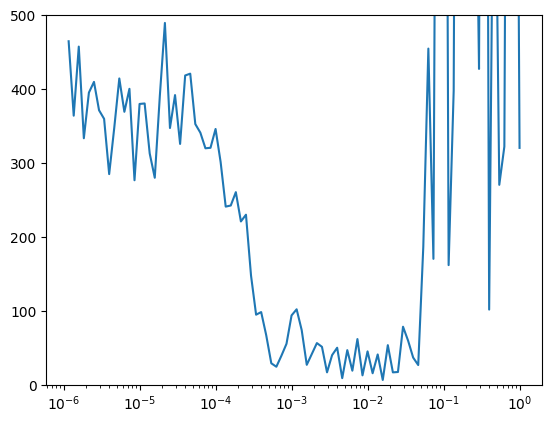

In [ ]:
plt.plot(lrs,losses)
plt.xscale('log')
#plt.yscale('log')
plt.ylim([0,500])
plt.show()

### Training

In [ ]:
opt_func.param_groups[0]['lr'] = 3e-4

In [ ]:
n_epochs = 30
train_loss, val_loss = [], []

for epoch in range(n_epochs):

  # Training

  train_loss_batch = 0.

  model.train()
  for inputs, labels in dl_train:
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs.requires_grad = True

    opt_func.zero_grad()

    outputs = model(inputs)
    loss = mse_loss_ode(model,inputs,labels)
    loss.backward()
    opt_func.step()

    train_loss_batch += loss.item()

  # Validation

  val_loss_batch = 0.

  model.eval()
  for inputs, labels in dl_valid:
    inputs = inputs.to(device)
    labels = labels.to(device)

    inputs.requires_grad = True

    outputs = model(inputs)
    loss = mse_loss_ode(model,inputs,labels)

    val_loss_batch += loss.item()

  train_loss.append(train_loss_batch/len(dl_train))
  val_loss.append(val_loss_batch/len(dl_train))
  print("Epoch: {}    Train Loss: {:.10f}    Val loss: {:.10f}".format(epoch, train_loss[epoch], val_loss[epoch]))

Epoch: 0    Train Loss: 29.4335153262    Val loss: 0.3596668111
Epoch: 1    Train Loss: 3.0237216870    Val loss: 0.2789056857
Epoch: 2    Train Loss: 2.2870909135    Val loss: 0.2043587897
Epoch: 3    Train Loss: 1.6439533373    Val loss: 0.1416548782
Epoch: 4    Train Loss: 1.1214664605    Val loss: 0.0944264299
Epoch: 5    Train Loss: 0.7231286274    Val loss: 0.0619792153
Epoch: 6    Train Loss: 0.4475474136    Val loss: 0.0361893718
Epoch: 7    Train Loss: 0.2755077095    Val loss: 0.0230317883
Epoch: 8    Train Loss: 0.1859166340    Val loss: 0.0166765979
Epoch: 9    Train Loss: 0.1412303496    Val loss: 0.0142154242
Epoch: 10    Train Loss: 0.1190408850    Val loss: 0.0113603449
Epoch: 11    Train Loss: 0.0990616591    Val loss: 0.0098675518
Epoch: 12    Train Loss: 0.0881490772    Val loss: 0.0089658599
Epoch: 13    Train Loss: 0.0844709425    Val loss: 0.0078814038
Epoch: 14    Train Loss: 0.0724408029    Val loss: 0.0070000118
Epoch: 15    Train Loss: 0.0637638738    Val loss

In [ ]:
opt_func.param_groups[0]['lr']

0.0003

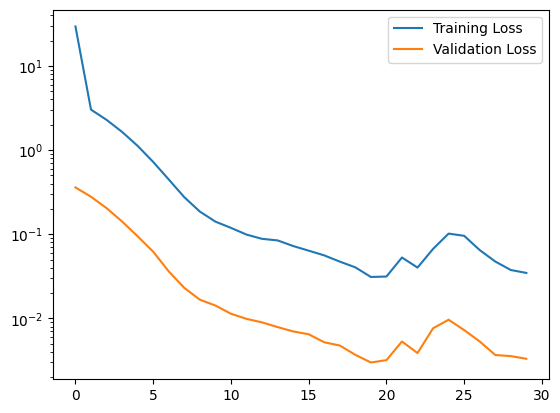

In [ ]:
plt.plot(range(n_epochs),train_loss,label='Training Loss')
plt.plot(range(n_epochs),val_loss,label='Validation Loss')
plt.yscale('log')
plt.legend()
plt.show()

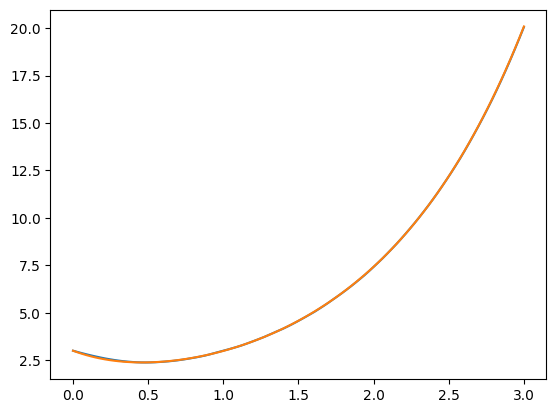

In [ ]:
t = torch.linspace(0,3,100).unsqueeze(-1).cuda()
NNt = model(t).detach().cpu()
t = t.cpu()

yt = t*NNt + 3
ytrue = 2*torch.exp(-2*t) + torch.exp(t)
plt.plot(t,yt)
plt.plot(t,ytrue)
plt.show()

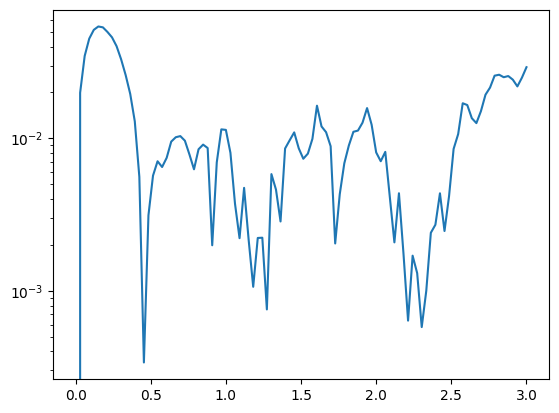

In [ ]:
plt.plot(t,abs(yt-ytrue))
plt.yscale('log')
plt.show()